In [1]:
# Importing libraries
import pandas as pd
from numpy import *
import yfinance as yf
from scipy.stats import norm

# Plotting
import matplotlib.pyplot as plt
from tabulate import tabulate

# Set max row to 300
pd.set_option('display.max_rows', 300)


In [2]:
class BS:
    
    """
    This is a class for Options contract for pricing European options on stocks without dividends.
    
    Attributes: 
        spot          : int or float
        strike        : int or float 
        rate          : float
        dte           : int or float [days to expiration in number of years]
        volatility    : float
    """    
    
    def __init__(self, spot, strike, rate, dte, volatility):
        
        # Spot Price
        self.spot = spot
        
        # Option Strike
        self.strike = strike
        
        # Interest Rate
        self.rate = rate
        
        # Days To Expiration
        self.dte = dte
        
        # Volaitlity
        self.volatility = volatility
       
        # Utility 
        self._a_ = self.volatility * self.dte**0.5
        
        if self.strike == 0:
            raise ZeroDivisionError('The strike price cannot be zero')
        else:
            self._d1_ = (log(self.spot / self.strike) + \
                     (self.rate + (self.volatility**2) / 2) * self.dte) / self._a_
        
        self._d2_ = self._d1_ - self._a_
        
        self._b_ = e**-(self.rate * self.dte)
        
        
        # The __dict__ attribute
        '''
        Contains all the attributes defined for the object itself. It maps the attribute name to its value.
        '''
        for i in ['callPrice', 'putPrice', 'callDelta', 'putDelta', 'callTheta', 'putTheta', \
                  'callRho', 'putRho', 'vega', 'gamma']:
            self.__dict__[i] = None
        
        [self.callPrice, self.putPrice] = self._price()
        [self.callDelta, self.putDelta] = self._delta()
        [self.callTheta, self.putTheta] = self._theta()
        [self.callRho, self.putRho] = self._rho()
        self.vega = self._vega()
        self.gamma = self._gamma()
        
    
    # Option Price
    def _price(self):
        '''Returns the option price: [Call price, Put price]'''

        if self.volatility == 0 or self.dte == 0:
            call = maximum(0.0, self.spot - self.strike)
            put = maximum(0.0, self.strike - self.spot)
        else:
            call = self.spot * norm.cdf(self._d1_) - self.strike * e**(-self.rate * \
                                                                       self.dte) * norm.cdf(self._d2_)

            put = self.strike * e**(-self.rate * self.dte) * norm.cdf(-self._d2_) - \
                                                                        self.spot * norm.cdf(-self._d1_)
        return [call, put]

    # Option Delta
    def _delta(self):
        '''Returns the option delta: [Call delta, Put delta]'''

        if self.volatility == 0 or self.dte == 0:
            call = 1.0 if self.spot > self.strike else 0.0
            put = -1.0 if self.spot < self.strike else 0.0
        else:
            call = norm.cdf(self._d1_)
            put = -norm.cdf(-self._d1_)
        return [call, put]

    # Option Gamma
    def _gamma(self):
        '''Returns the option gamma'''
        return norm.pdf(self._d1_) / (self.spot * self._a_)

    # Option Vega
    def _vega(self):
        '''Returns the option vega'''
        if self.volatility == 0 or self.dte == 0:
            return 0.0
        else:
            return self.spot * norm.pdf(self._d1_) * self.dte**0.5 / 100

    # Option Theta
    def _theta(self):
        '''Returns the option theta: [Call theta, Put theta]'''
        call = -self.spot * norm.pdf(self._d1_) * self.volatility / (2 * self.dte**0.5) - self.rate * self.strike * self._b_ * norm.cdf(self._d2_)

        put = -self.spot * norm.pdf(self._d1_) * self.volatility / (2 * self.dte**0.5) + self.rate * self.strike * self._b_ * norm.cdf(-self._d2_)
        return [call / 365, put / 365]

    # Option Rho
    def _rho(self):
        '''Returns the option rho: [Call rho, Put rho]'''
        call = self.strike * self.dte * self._b_ * norm.cdf(self._d2_) / 100
        put = -self.strike * self.dte * self._b_ * norm.cdf(-self._d2_) / 100

        return [call, put]

In [3]:
# Initialize option
option = BS(100,100,0.0,1,0.2)

header = ['Option Price', 'Delta', 'Gamma', 'Theta', 'Vega', 'Rho']
table = [[option.callPrice, option.callDelta, option.gamma, option.callTheta, option.vega, option.callRho]]

print(tabulate(table,header))

  Option Price     Delta      Gamma       Theta      Vega       Rho
--------------  --------  ---------  ----------  --------  --------
       7.96557  0.539828  0.0198476  -0.0108754  0.396953  0.460172


In [4]:
# Get SPY option chain
spy = yf.Ticker('SPY')
options = spy.option_chain('2023-03-31')

In [5]:
# March 2023 400 SPY call option price
spot = 400; strike = 400; rate = 0.0; dte = 0.0575; vol = 0.1805

spy_opt = BS(spot,strike,rate,dte,vol)
print(f'Option Price of SPY230331C00400000 with BS Model is {spy_opt.callPrice:0.4f}')

Option Price of SPY230331C00400000 with BS Model is 6.9063


In [6]:
# Filter calls for strike at or above 400
df = options.calls[options.calls['strike']>=400]
df.reset_index(drop=True, inplace=True)

# Dataframe manipulation with selected fields
df = pd.DataFrame({'Strike': df['strike'], 
                   'Price': df['lastPrice'], 
                   'ImpVol': df['impliedVolatility']})

# Derive greeks and assign to dataframe as columns
df['Delta'] = df['Gamma'] = df['Vega'] = df['Theta'] = 0.

for i in range(len(df)):
    
    df['Delta'].iloc[i] = BS(spot,df['Strike'].iloc[i],rate,dte,df['ImpVol'].iloc[i]).callDelta
    df['Gamma'].iloc[i] = BS(spot,df['Strike'].iloc[i],rate,dte,df['ImpVol'].iloc[i]).gamma
    df['Vega'].iloc[i] = BS(spot,df['Strike'].iloc[i],rate,dte,df['ImpVol'].iloc[i]).vega
    df['Theta'].iloc[i] = BS(spot,df['Strike'].iloc[i],rate,dte,df['ImpVol'].iloc[i]).callTheta

# Check output
df.head(2)

,Strike,Price,ImpVol,Delta,Gamma,Vega,Theta
0,400.0,1.11,0.167611,0.508017,0.024810,0.382575,-0.152766
1,401.0,0.82,0.162606,0.482237,0.025553,0.382273,-0.148088


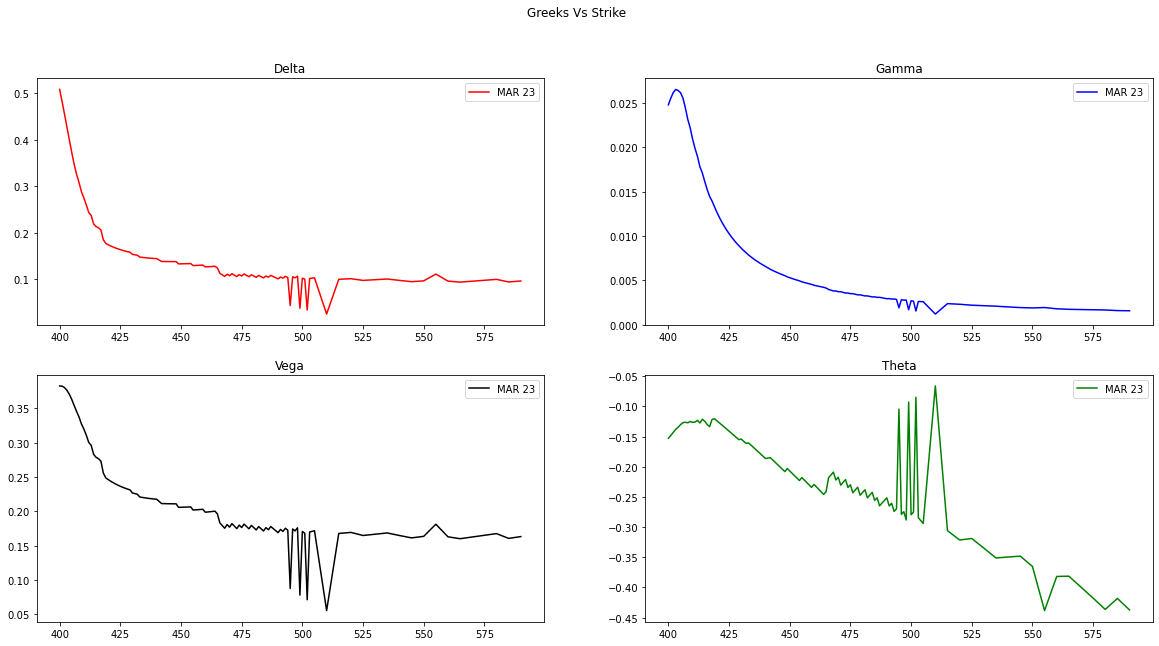

In [7]:
# Plot graph iteratively
fig, ax = plt.subplots(2,2, figsize=(20,10))

ax[0,0].plot(df['Strike'], df['Delta'], color='r', label='MAR 23')
ax[0,1].plot(df['Strike'], df['Gamma'], color='b', label='MAR 23')
ax[1,0].plot(df['Strike'], df['Vega'], color='k', label='MAR 23')
ax[1,1].plot(df['Strike'], df['Theta'], color='g', label='MAR 23')
    
# Set axis title
ax[0,0].set_title('Delta'), ax[0,1].set_title('Gamma'), ax[1,0].set_title('Vega'), ax[1,1].set_title('Theta')

# Define legend
ax[0,0].legend(), ax[0,1].legend(), ax[1,0].legend(), ax[1,1].legend()

# Set title
fig.suptitle('Greeks Vs Strike')

plt.show()